Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


100%|██████████| 700/700 [04:54<00:00,  2.38it/s]


0.9812


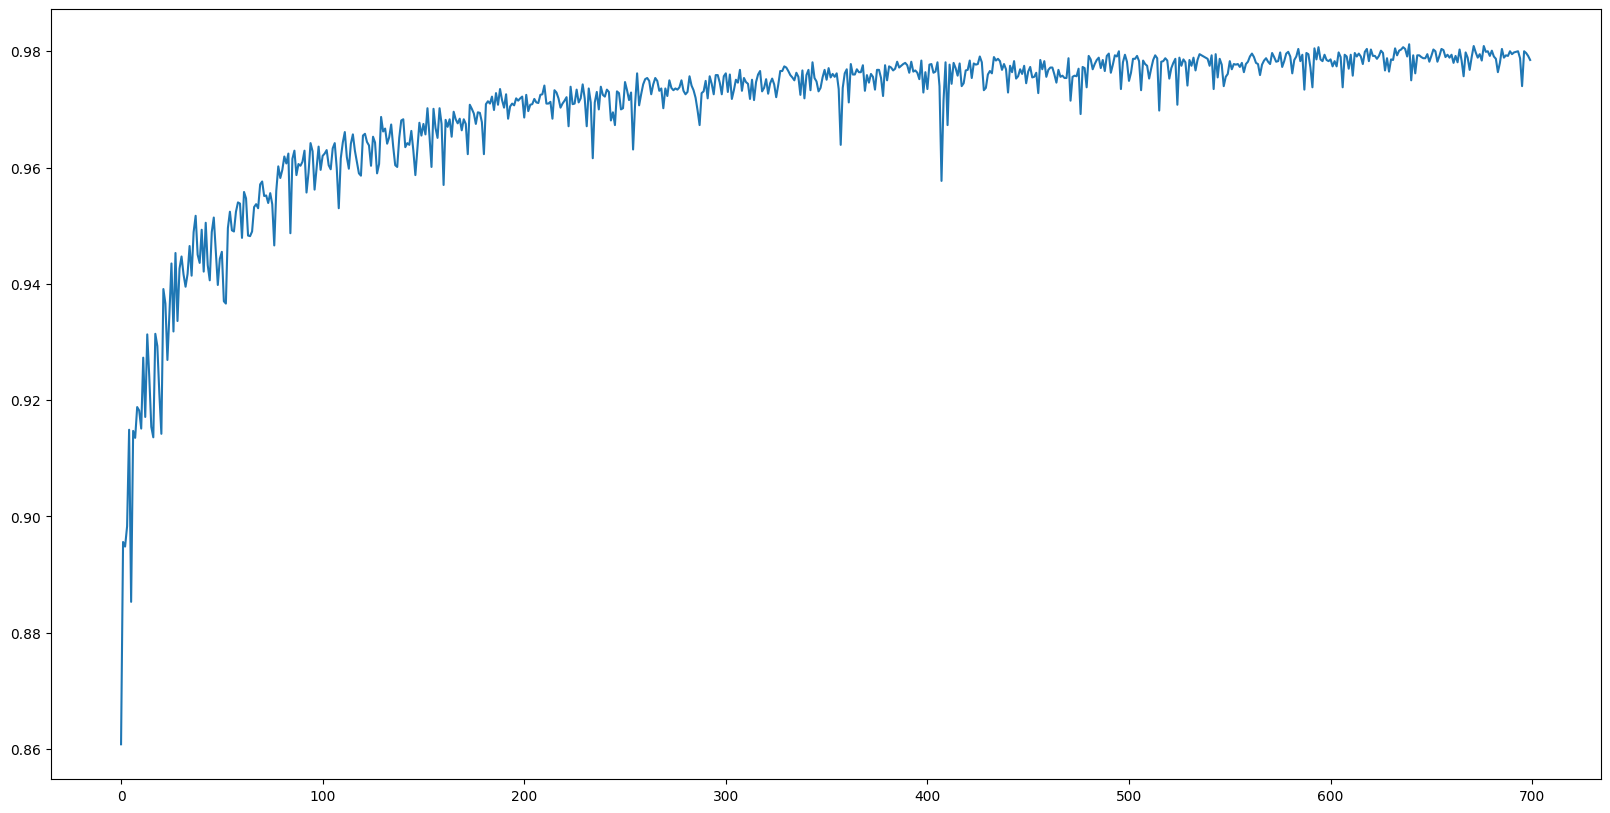

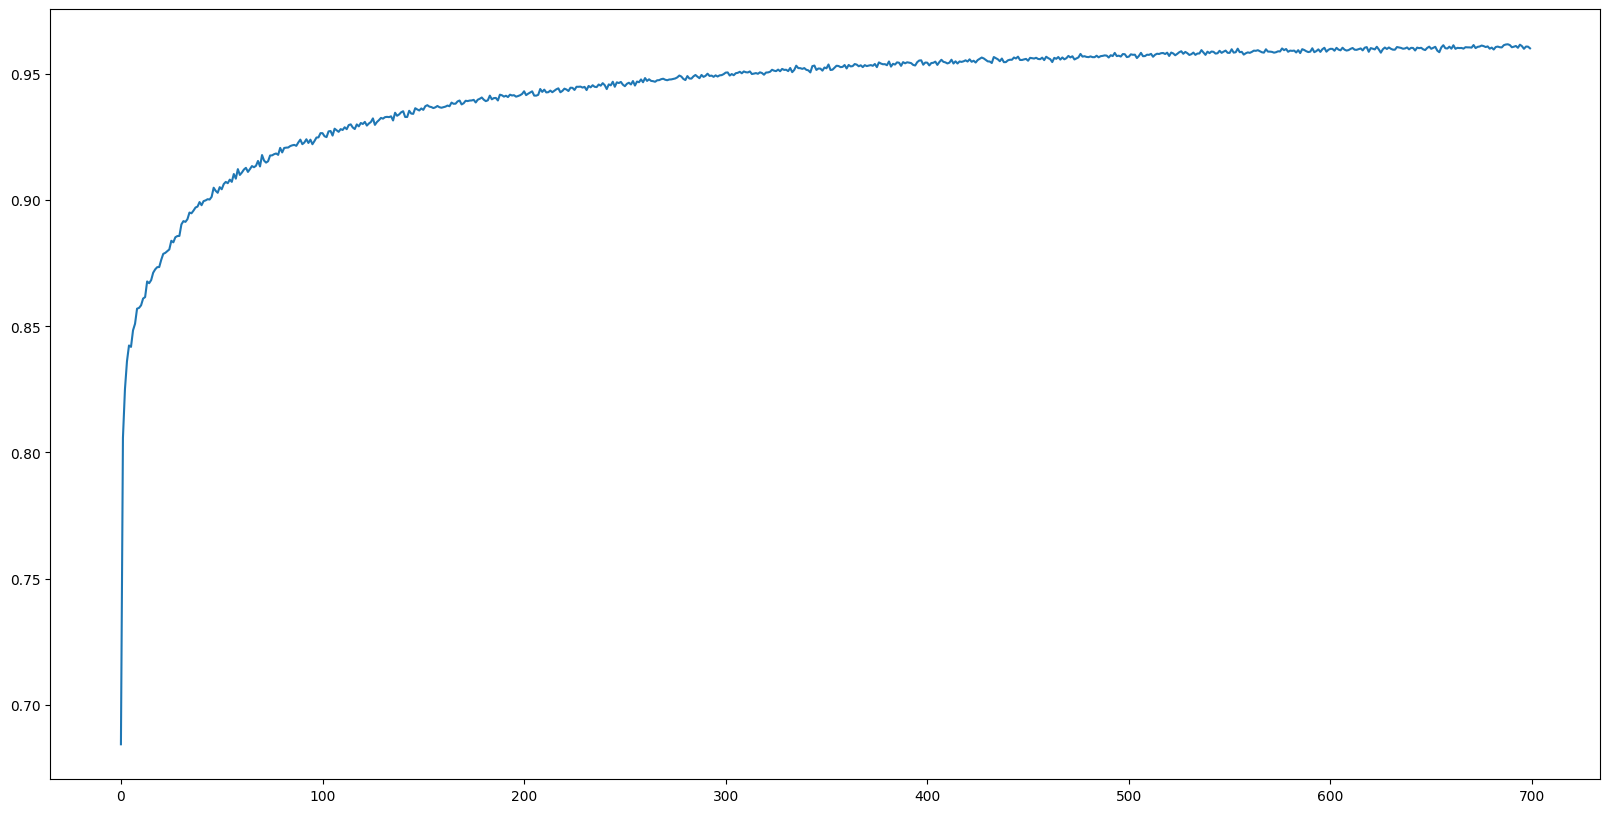

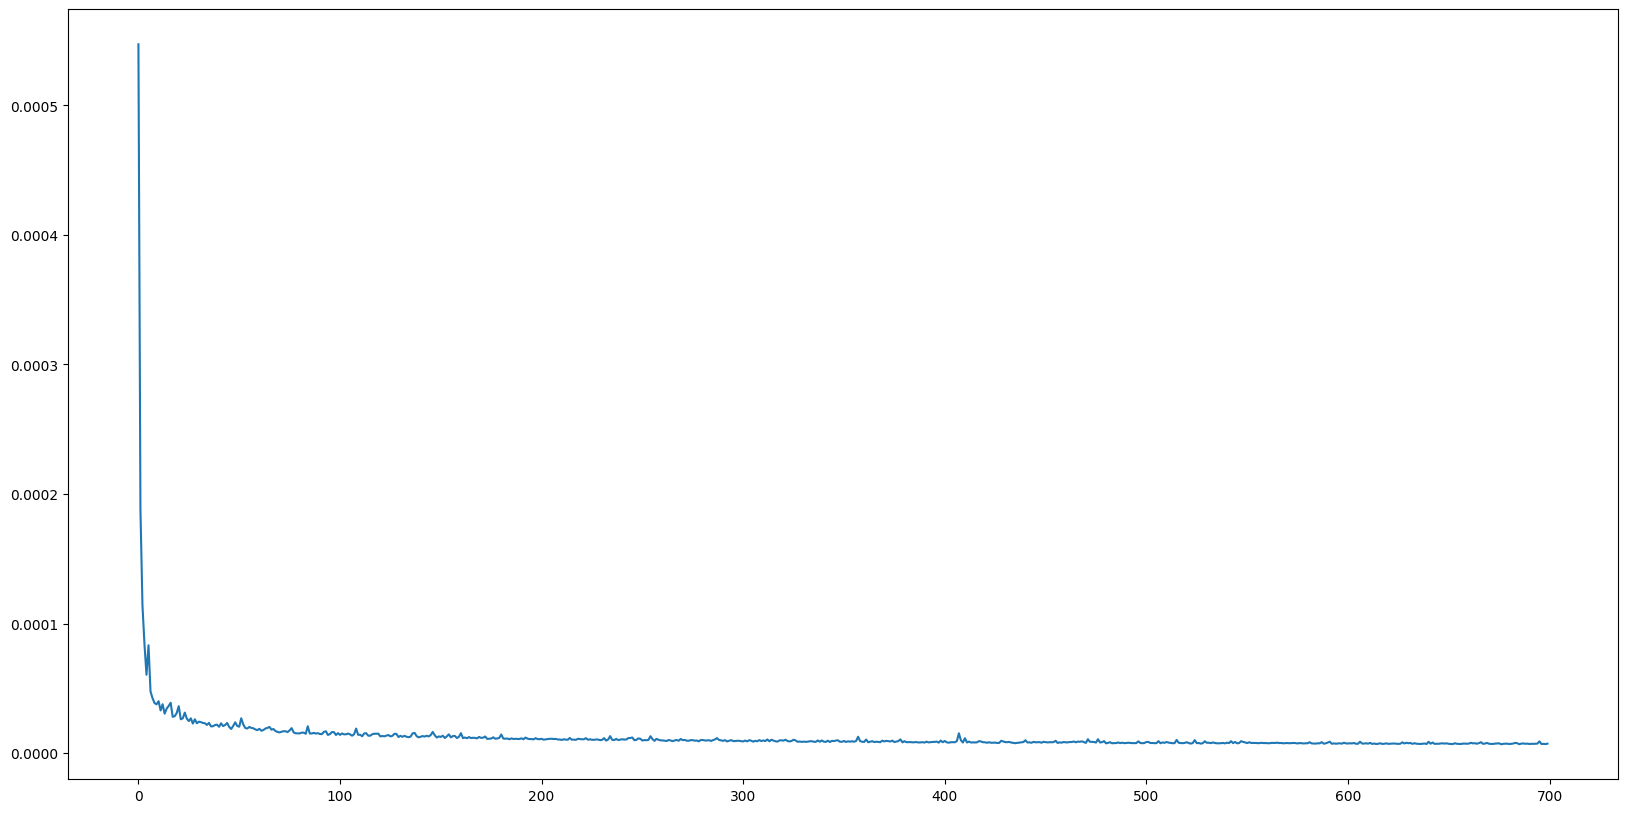

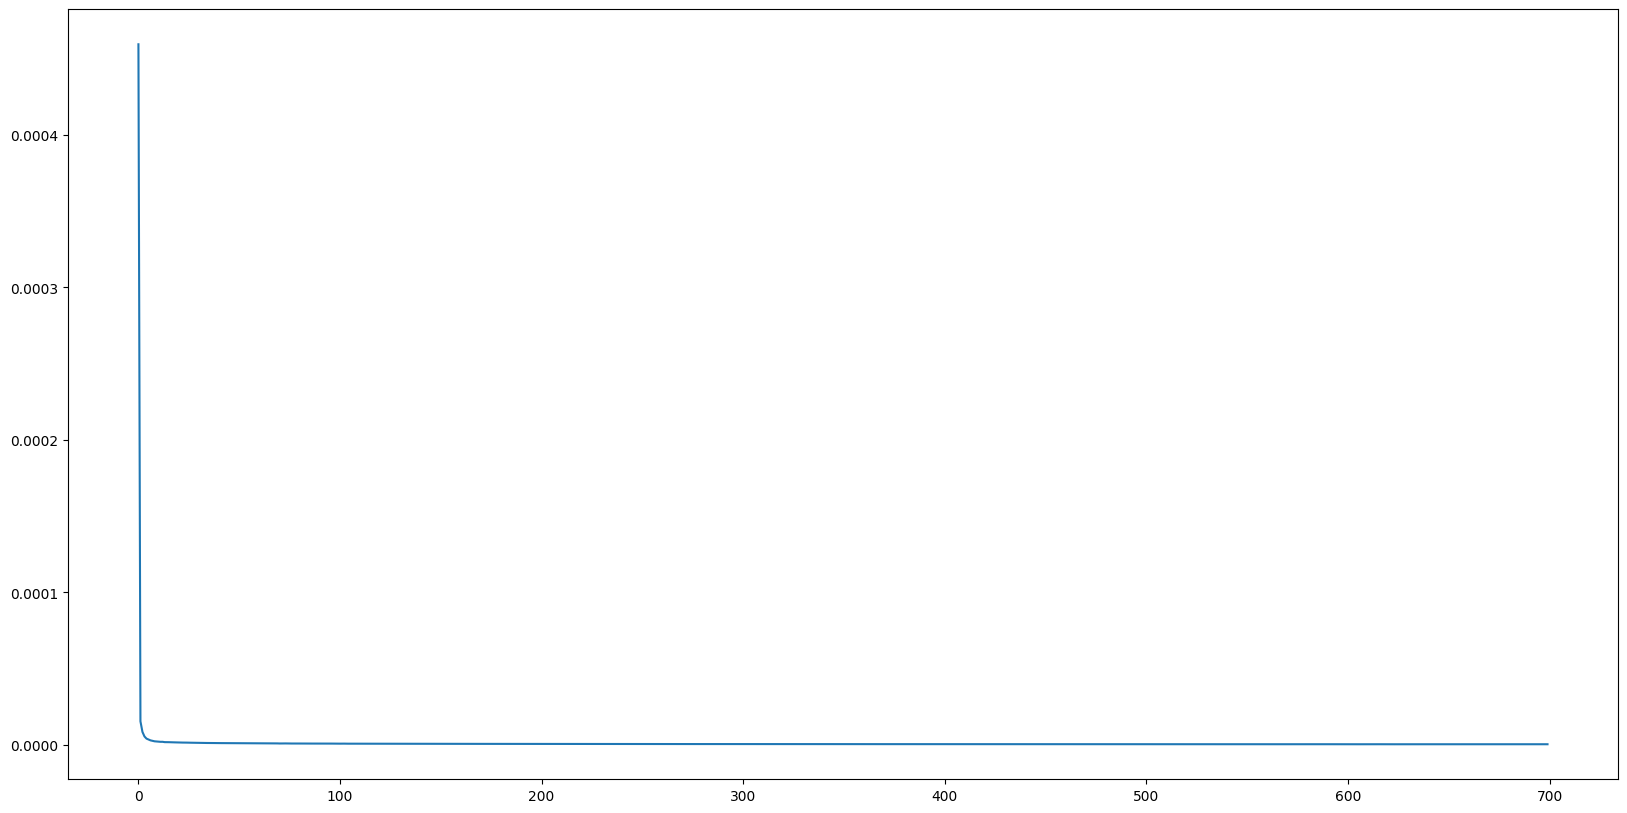

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorboard
import random
from tqdm import tqdm
import torchvision
import torchvision.datasets as datasets
from PIL import Image
import torchvision.transforms as transforms

def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum()

def leaky_relu(x, negative_slope=0.01):
    return torch.max(x, negative_slope * x)

def leaky_relu_derivative(x, negative_slope=0.01):
    # Derivative when x >= 0
    dx_positive = torch.ones_like(x)
    # Derivative when x < 0
    dx_negative = negative_slope * torch.ones_like(x)

    # Combine the two cases using a mask
    mask = x >= 0
    derivative = dx_positive * mask + dx_negative * ~mask

    return derivative

def train_perceptron(X:torch.Tensor,W_hidden:torch.Tensor,b_hidden:torch.Tensor,W_output:torch.Tensor,b_output:torch.Tensor,y_true:torch.Tensor,lr:float,batch_size:int,non_blocking: bool):
    z_hid=X@W_hidden+b_hidden
    mask = torch.bernoulli(torch.full((z_hid.shape[1],), 1 - 0.1)).to(device,non_blocking=non_blocking)
    a_hid=leaky_relu(z_hid)* mask / (1 - 0.1)
    #a_hid = a_hid * mask / (1 - 0.1)
    z_out=a_hid@W_output+b_output
    y_pred=z_out.softmax(dim=1)
    d_z_out=y_pred-y_true
    d_a_hid=d_z_out@W_output.T
    d_z_hid=d_a_hid*leaky_relu_derivative(a_hid)

    # dW_out=(1/batch_size)*a_hid.T@d_z_out
    # db_out=torch.mean(d_z_out,axis=0,keepdims=True)
    # dW_hid=(1/batch_size)*X.T@d_z_hid
    # db_hid=torch.mean(d_z_hid,axis=0,keepdims=True)


    W_output=W_output-lr*((1/batch_size)*a_hid.T@d_z_out)
    b_output=b_output-lr*(torch.mean(d_z_out,axis=0,keepdims=True))
    W_hidden=W_hidden-lr*((1/batch_size)*X.T@d_z_hid)
    b_hidden=b_hidden-lr*(torch.mean(d_z_hid,axis=0,keepdims=True))
    return W_hidden,b_hidden,W_output,b_output,((torch.nn.functional.cross_entropy(z_out,y_true))/batch_size).to('cpu').item(),((torch.argmax(y_pred,dim=1)==torch.argmax(y,dim=1)).sum()).item()

def inference(X:torch.Tensor,W_hidden:torch.Tensor,b_hidden:torch.Tensor,W_output:torch.Tensor,b_output:torch.Tensor):
    return ((leaky_relu(X@W_hidden+b_hidden))@W_output+b_output)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
print(mnist_trainset)
print(mnist_testset)
transform = transforms.Compose([
    transforms.PILToTensor()
])
train_data=[]
train_labels=[]
test_data=[]
test_labels=[]
shift=1
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor

for x in mnist_trainset:
    y=torch.zeros((1,10))
    y[0][x[1]]=1
    img=transform(x[0])[0]
    #img=(torch.reshape(transform(x[0])[0],(1,784))/255)

    shifted_part = img[:, :-shift]
    cropped_part = img[:, -shift:]
    zero_pad = torch.zeros_like(cropped_part)
    shifted_image_right = torch.cat([zero_pad, shifted_part], dim=1)

    shifted_part = img[:, shift:]
    cropped_part = img[:, :shift]
    zero_pad = torch.zeros_like(cropped_part)
    shifted_image_left = torch.cat([shifted_part, zero_pad], dim=1)

    shifted_part = img[shift:, :]
    cropped_part = img[:shift, :]
    zero_pad = torch.zeros_like(cropped_part)
    shifted_image_up = torch.cat([shifted_part, zero_pad], dim=0)

    shifted_part = img[:-shift, :]
    cropped_part = img[-shift:, :]
    zero_pad = torch.zeros_like(cropped_part)
    shifted_image_down = torch.cat([zero_pad, shifted_part], dim=0)

    img=(torch.reshape(img,(1,784))/255)
    #print(img)
    shifted_image_right=(torch.reshape(shifted_image_right,(1,784))/255)
    shifted_image_left=(torch.reshape(shifted_image_left,(1,784))/255)
    shifted_image_up=(torch.reshape(shifted_image_up,(1,784))/255)
    shifted_image_down=(torch.reshape(shifted_image_down,(1,784))/255)
    train_data.append(img)
    train_labels.append(y)
    train_data.append(shifted_image_down)
    train_labels.append(y)
    train_data.append(shifted_image_up)
    train_labels.append(y)
    train_data.append(shifted_image_right)
    train_labels.append(y)
    train_data.append(shifted_image_left)
    train_labels.append(y)

for x in mnist_testset:
    y=torch.zeros((1,10))
    y[0][x[1]]=1
    test_data.append(torch.reshape(transform(x[0])[0],(1,784))/255)
    test_labels.append(y)

non_blocking= device=='cuda'
if device=='cuda':
  test_data=torch.concat(test_data,dim=0).pin_memory().to(device,non_blocking=non_blocking)
  test_labels=torch.concat(test_labels,dim=0).pin_memory().to(device,non_blocking=non_blocking)
  train_data=torch.concat(train_data,dim=0).pin_memory().to(device,non_blocking=non_blocking)
  train_labels=torch.concat(train_labels,dim=0).pin_memory().to(device,non_blocking=non_blocking)
else:
  test_data=torch.concat(test_data,dim=0).to(device,non_blocking=non_blocking)
  test_labels=torch.concat(test_labels,dim=0).to(device,non_blocking=non_blocking)
  train_data=torch.concat(train_data,dim=0).to(device,non_blocking=non_blocking)
  train_labels=torch.concat(train_labels,dim=0).to(device,non_blocking=non_blocking)

epochs=700
init_lr=0.05
batch_size=500
w1=torch.rand((784,100))
b1=torch.rand((1,100))
w2=torch.rand((100,10))
b2=torch.rand((1,10))
best_w1=w1
best_b1=b1
best_w2=w2
best_b2=b2

val_res=[]
max_val=0
scheduler=0
varia=tqdm(range(epochs))
w1=w1.to(device,non_blocking=non_blocking)
b1=b1.to(device,non_blocking=non_blocking)
w2=w2.to(device,non_blocking=non_blocking)
b2=b2.to(device,non_blocking=non_blocking)

batch_size=600
test_batch_size=10000
iter=-1
total_loss=[]
total_acc=[]
total_loss_val=[]
lr=init_lr
lossu=0
for epoch in varia:
    #lr = poly_lr(epoch, epochs, init_lr, 0.9)
    if epoch%20==0:
      #print("buna")
      order=torch.randperm(len(train_data))
      train_data=train_data[order][:][:]
      train_labels=train_labels[order][:][:]
    i=0
    iter+=1

    #random.shuffle(train_data)
    #print(train_data.shape)
    acc=0
    lossu=0
    while i+batch_size-1<len(train_data):
        x=train_data[i:i+batch_size]#.to('cuda')
        y=train_labels[i:i+batch_size]#.to('cuda')
        w1,b1,w2,b2,loss,ac=train_perceptron(x,w1,b1,w2,b2,y,lr,batch_size,non_blocking)
        lossu+=loss
        acc+=ac
        i+=batch_size
    total_loss.append(lossu/len(train_data))
    total_acc.append(acc/len(train_data))
    corr=0
    i=0
    while i+test_batch_size-1<len(test_data):
        x=test_data[i:i+test_batch_size]#.to('cuda')
        y=test_labels[i:i+test_batch_size]#.to('cuda')
        y_pred=inference(x,w1,b1,w2,b2)
        total_loss_val.append((torch.nn.functional.cross_entropy(y_pred,y)/test_batch_size).to('cpu').item())
        #y_pred=torch.argmax(y_pred,dim=1)
        # print(y_pred)
        # print(torch.argmax(y,dim=1))
        corr+=(torch.argmax(y_pred.softmax(dim=1),dim=1)==torch.argmax(y,dim=1)).sum().item()
        i+=test_batch_size
    #print(len(test_data))
    acc=corr/len(test_data)
    #print(mr)
    scheduler+=1
    if acc>max_val:
        #print(max_val)
        scheduler=0
        max_val=acc
        best_w1=w1
        best_b1=b1
        best_w2=w2
        best_b2=b2
    if scheduler==100 and iter>200:
        print(max_val)
        scheduler=0
        lr=lr/2
    #varia.set_postfix_str(f"train_accuracy = {total_acc[-1]}, train_loss = {total_loss[-1]},val_accuracy={acc} ,val_loss={total_loss_val[-1]}, max_val_acc={max_val}")


    val_res.append(acc)

print(max_val)
plt.figure(figsize=(20,10))
plt.plot(val_res)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(total_acc)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(total_loss_val)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(total_loss)
plt.show()